# How many zero and low emissions vehicles are registered in California?

### Load Python tools

In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import geopandas as gpd
import altair as alt
import altair_grid as altgrid
import numpy as np
import jenkspy
import matplotlib
import matplotlib.pyplot as plt
from pywaffle import Waffle

/Users/stiles/.local/share/virtualenvs/grid-notebooks-Amv9DX-2/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [3]:
alt.themes.register("grid", altgrid.theme)
alt.themes.enable("grid")

ThemeRegistry.enable('grid')

In [4]:
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 10000
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [5]:
today = pd.to_datetime("today").strftime("%Y-%m-%d")

### Read data from California Department of Motor Vehicles - current as of Jan. 1, 2021

In [6]:
# https://data.ca.gov/dataset/vehicle-fuel-type-count-by-zip-code
url = "https://data.ca.gov/dataset/15179472-adeb-4df6-920a-20640d02b08c/resource/888bbb6c-09b4-469c-82e6-1b2a47439736/download/vehicle-fuel-type-count-by-zip-code-2021.csv"

In [7]:
src = pd.read_csv(url, low_memory=False)

### Clean up field names

In [8]:
src.columns = (
    src.columns.str.strip()
    .str.lower()
    .str.replace(" ", "_", regex=False)
    .str.replace("(", "", regex=False)
    .str.replace(")", "", regex=False)
    .str.replace("-", "_", regex=False)
)

In [9]:
src.rename(columns={"zip_code": "zip"}, inplace=True)

### How many vehicles are we talking about? 

In [10]:
"{:,.0f}".format(src.vehicles.sum())

'29,599,519'

In [11]:
src.model_year.value_counts().sort_values()

2021     13946
2009     28101
2010     31589
2008     36613
2011     38397
2020     41257
2012     42860
2013     46144
2014     46972
2018     49670
2019     50185
2015     50404
2016     50815
2017     53043
<2008    97973
Name: model_year, dtype: int64

### Remove older vehicles

In [12]:
exclude = ["<2008", "2009", "2010"]

In [13]:
vehicles = src[~src["model_year"].isin(exclude)]

In [14]:
"{:,.0f}".format(vehicles.vehicles.sum())

'17,734,556'

### How many don't rely solely on gasoline?

In [15]:
nogas = vehicles[(vehicles["fuel"] != "Gasoline")]

In [16]:
zev = vehicles[vehicles["fuel"] == "Battery Electric"]

In [17]:
cvrp = vehicles[
    (vehicles["fuel"] == "Battery Electric")
    | (vehicles["fuel"] == "Hydrogen Fuel Cell")
    | (vehicles["fuel"] == "Plug-in Hybrid")
]

In [18]:
"{:,.0f}".format(nogas.vehicles.sum())

'3,241,141'

### How many are battery electric, or otherwise CVRP eligible?

In [19]:
"{:,.0f}".format(cvrp.vehicles.sum())

'646,335'

In [20]:
"{:,.0f}".format(zev.vehicles.sum())

'374,757'

### Share of newer CA vehicles that don't rely solely on gas?

In [21]:
"{:,.1f}%".format((nogas.vehicles.sum() / vehicles.vehicles.sum()) * 100)

'18.3%'

### Share of CA vehicles that are battery electric, or otherwise CVRP eligible?

In [22]:
"{:,.1f}%".format((cvrp.vehicles.sum() / vehicles.vehicles.sum()) * 100)

'3.6%'

---

### ZIP codes points

In [23]:
zips_point = gpd.read_file("../../../data/gis/zipcodes.geojson")

In [24]:
zips_point["zip"] = zips_point["zip"].astype(str)

In [25]:
ca_zips_point = zips_point[zips_point["state"] == "CA"]

### ZIP codes boundaries

In [26]:
# Filtered CA from this national file maintained by Esri:
# https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/USA_ZIP_Code_Areas_anaylsis/FeatureServer/0/
zips_poly_pop = gpd.read_file("../../../data/gis/ca-zip-codes-esri.geojson")
zips_poly = gpd.read_file("../../../data/gis/ca-zip-codes-esri-demographics.geojson")

In [27]:
zips_poly.columns = (
    zips_poly.columns.str.strip()
    .str.lower()
    .str.replace(" ", "_", regex=False)
    .str.replace("(", "", regex=False)
    .str.replace(")", "", regex=False)
    .str.replace("-", "_", regex=False)
)

In [28]:
zips_poly.dropna(inplace=True)

In [29]:
zips_poly.rename(columns={"zip_code": "zip"}, inplace=True)

In [30]:
zips_poly.head()

,objectid,zip,po_name,pop2012,white,black,ameri_es,asian,hawn_pi,hispanic,other,mult_race,med_age,ave_hh_sz,marhh_chd,families,ave_fam_sz,hse_units,sqmi,geometry
0,4800,94002,Belmont,26832,19634,477,84,5762,221,3517,1170,1744,41.0,2.42,2925,7671,2.98,12304,5.9,"POLYGON ((-122.27703 37.53436, -122.27687 37.5..."
1,4801,94010,Burlingame,41102,31610,482,93,10244,188,5133,1865,2166,42.6,2.43,4798,12179,3.06,20020,13.0,"POLYGON ((-122.37728 37.60562, -122.37738 37.6..."
2,4900,93442,Morro Bay,10873,9395,47,104,281,10,1602,645,322,48.9,2.09,593,2749,2.70,6609,43.2,"POLYGON ((-120.77255 35.46196, -120.77270 35.4..."
3,4901,93445,Oceano,7633,4683,60,114,155,7,3389,1477,283,34.7,2.86,541,1582,3.42,2871,2.0,"POLYGON ((-120.63624 35.12213, -120.63591 35.1..."
4,4802,94015,Daly City,61575,14279,2138,168,35940,482,9775,4520,2939,39.0,3.10,4637,13991,3.54,20103,5.7,"POLYGON ((-122.50283 37.70813, -122.50242 37.7..."


---

### ZIP codes demographics from mapping giant Esri

In [31]:
# https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/WealthiestZipCodes2017/FeatureServer/0/
zips_wealth = gpd.read_file("../../../data/gis/WealthiestZipCodesCA.geojson")

In [32]:
zips_wealth.head()

,OBJECTID,ID,NAME,ST_ABBREV,HAI_CY,INCMORT_CY,WLTHRNK_CY,DOMSTATE,DOMCOUNTY,COUNTY_NAME,DOMCBSA,CBSA_NAME,TOTPOP_CY,TOTHH_CY,MEDAGE_CY,AVGHINC_CY,AVGVAL_CY,AVGNW_CY,Shape__Area,Shape__Length,geometry
0,29014,90001,Los Angeles,CA,55,44.1,27675.0,06,06037,Los Angeles County,31080,"Los Angeles-Long Beach-Anaheim, CA Metropolita...",59907,13454,27.1,46931,377591,82915,1.274793e+07,17936.346667,"POLYGON ((-118.24754 33.98908, -118.24776 33.9..."
1,29015,90002,Los Angeles,CA,59,41.2,27690.0,06,06037,Los Angeles County,31080,"Los Angeles-Long Beach-Anaheim, CA Metropolita...",53573,12115,26.7,46332,331694,96786,1.134827e+07,16650.994848,"POLYGON ((-118.24745 33.96015, -118.25169 33.9..."
2,29016,90003,Los Angeles,CA,52,46.6,28202.0,06,06037,Los Angeles County,31080,"Los Angeles-Long Beach-Anaheim, CA Metropolita...",71967,16771,27.1,43020,358057,66091,1.365974e+07,23821.373485,"MULTIPOLYGON (((-118.28268 33.98926, -118.2826..."
3,29017,90004,Los Angeles,CA,21,114.5,20202.0,06,06037,Los Angeles County,31080,"Los Angeles-Long Beach-Anaheim, CA Metropolita...",63987,23021,35.8,65893,909580,232653,1.090500e+07,22878.233455,"MULTIPOLYGON (((-118.33852 34.06891, -118.3371..."
4,29018,90005,Los Angeles,CA,22,111.5,26028.0,06,06037,Los Angeles County,31080,"Los Angeles-Long Beach-Anaheim, CA Metropolita...",41844,17067,35.8,53191,836569,105569,5.390883e+06,19394.836905,"POLYGON ((-118.31879 34.05514, -118.31861 34.0..."


In [33]:
zips_wealth_slim = zips_wealth[["ID", "NAME", "AVGHINC_CY", "AVGNW_CY", "TOTPOP_CY"]]

In [34]:
zips_esri = zips_wealth_slim.rename(
    columns={
        "ID": "zip",
        "NAME": "name",
        "AVGHINC_CY": "avg_house_income",
        "AVGNW_CY": "avg_net_worth",
        "TOTPOP_CY": "population",
    }
)

In [35]:
zips_esri.head()

,zip,name,avg_house_income,avg_net_worth,population
0,90001,Los Angeles,46931,82915,59907
1,90002,Los Angeles,46332,96786,53573
2,90003,Los Angeles,43020,66091,71967
3,90004,Los Angeles,65893,232653,63987
4,90005,Los Angeles,53191,105569,41844


In [36]:
zips_esri[zips_esri["name"] == "Atherton"]
zips_esri["avg_house_income"].mean()

89398.97781569966

In [37]:
zips_esri.to_csv("data/processed/zip_demographics.csv", index=False)
vehicles[vehicles["zip"] != "OOS"].to_csv(
    "data/processed/vehicle-count.csv", index=False
)

---

### Group the vehicles and count them by the registration ZIP code

In [38]:
zipcodes = vehicles.groupby(["zip"]).agg({"vehicles": "sum"}).reset_index()

In [39]:
zipcodes.sort_values(by="vehicles", ascending=False).head(10)
zipcodes["zip"] = zipcodes["zip"].astype(str)

### Merge the registration zip codes and merge with Esri zipcode polygons

In [40]:
zips = pd.merge(zips_esri, zipcodes, left_on="zip", right_on="zip")

In [41]:
zips.head()

,zip,name,avg_house_income,avg_net_worth,population,vehicles
0,90001,Los Angeles,46931,82915,59907,15703
1,90002,Los Angeles,46332,96786,53573,14547
2,90003,Los Angeles,43020,66091,71967,18821
3,90004,Los Angeles,65893,232653,63987,19561
4,90005,Los Angeles,53191,105569,41844,11005


---

### Group by duty. Which are most common among ALL vehicles? 

In [42]:
# About 2.5 are listed as OTHER/UNK
duty_totals = vehicles.groupby(["duty"]).agg("sum").reset_index()
duty_totals.head()

,duty,vehicles
0,Heavy,597543
1,Light,16333571
2,Unk,803442


### Group by make. Which are most common? 

In [43]:
# About 2.5 are listed as OTHER/UNK
make = (
    vehicles[vehicles["make"] != "OTHER/UNK"]
    .groupby(["make", "zip"])
    .agg("sum")
    .reset_index()
)

In [44]:
most_make = (
    make.groupby(["make"])
    .agg("sum")
    .reset_index()
    .sort_values(by="vehicles", ascending=False)
)

In [45]:
most_make.head()

,make,vehicles
80,TOYOTA,3013534
28,HONDA,2089476
21,FORD,1395935
58,NISSAN,1172121
16,CHEVROLET,1105157


In [46]:
makelist = most_make.make.to_list()

In [47]:
popular_makes = make[make["make"].isin(makelist)]

In [48]:
make_zip = pd.DataFrame(
    pd.pivot_table(
        popular_makes,
        values="vehicles",
        index=["zip"],
        columns=["make"],
        aggfunc=np.sum,
        fill_value=0,
    ).reset_index()
)

In [49]:
make_zip.columns = (
    make_zip.columns.str.strip()
    .str.lower()
    .str.replace(" ", "_", regex=False)
    .str.replace("(", "", regex=False)
    .str.replace(")", "", regex=False)
    .str.replace("-", "_", regex=False)
)

---

## Isolate vehicle makes to include only Teslas

In [50]:
tesla = vehicles[(vehicles["make"] == "TESLA")]

In [51]:
len(tesla)

4323

### How many Teslas? 

In [52]:
tesla["vehicles"].sum()

239405

### Group by ZIP code and count the vehicles

In [53]:
tesla_grouped = tesla.groupby(["zip"]).agg({"vehicles": "sum"}).reset_index()

### Merge with dataframe that includes all vehicle counts by ZIP code

In [54]:
tesla_zips = pd.merge(tesla_grouped, zips, on="zip")

### Rename the columns

In [55]:
tesla_zips.rename(
    columns={
        "median": "income",
        "zip": "zip",
        "vehicles_x": "teslas",
        "vehicles_y": "all_vehicles",
    },
    inplace=True,
)

### Normalize Tesla ownership to a rate per 1,000 vehicles

In [56]:
tesla_zips["tesla_rate_1k"] = (
    (tesla_zips.teslas / tesla_zips.all_vehicles) * 1000
).round(2)

In [57]:
tesla_zips.sort_values(by="tesla_rate_1k", ascending=False).head(10)

,zip,teslas,name,avg_house_income,avg_net_worth,population,all_vehicles,tesla_rate_1k
590,94027,564,Atherton,297732,3680197,7230,4291,131.44
587,94022,1393,Los Altos,248970,3041961,20626,11640,119.67
636,94301,869,Palo Alto,224861,1760729,18694,7778,111.73
588,94024,1364,Los Altos,259185,3442702,23198,12643,107.89
591,94028,427,Portola Valley,263238,3322715,6639,4063,105.09
777,95070,1824,Saratoga,243915,3157204,32730,17693,103.09
432,92657,697,Newport Coast,244565,2836260,11464,6957,100.19
764,95030,678,Los Gatos,233429,2476366,13618,7963,85.14
87,90402,501,Santa Monica,206819,2163557,13154,5995,83.57
670,94539,2210,Fremont,198198,2070851,54673,27057,81.68


In [58]:
tesla_breaks = jenkspy.jenks_breaks(tesla_zips.tesla_rate_1k, nb_class=6)
tesla_breaks

[0.4, 9.28, 20.39, 35.41, 55.99, 85.14, 131.44]

In [59]:
tesla_zips.to_csv("output/tesla_zips.csv")

In [60]:
tesla_zips_slim = pd.DataFrame(
    tesla_zips[
        [
            "zip",
            "name",
            "teslas",
            "all_vehicles",
            "tesla_rate_1k",
            "avg_house_income",
            "avg_net_worth",
        ]
    ]
)

In [61]:
tesla_zips_slim.sort_values(by="tesla_rate_1k", ascending=False).head(10)

,zip,name,teslas,all_vehicles,tesla_rate_1k,avg_house_income,avg_net_worth
590,94027,Atherton,564,4291,131.44,297732,3680197
587,94022,Los Altos,1393,11640,119.67,248970,3041961
636,94301,Palo Alto,869,7778,111.73,224861,1760729
588,94024,Los Altos,1364,12643,107.89,259185,3442702
591,94028,Portola Valley,427,4063,105.09,263238,3322715
777,95070,Saratoga,1824,17693,103.09,243915,3157204
432,92657,Newport Coast,697,6957,100.19,244565,2836260
764,95030,Los Gatos,678,7963,85.14,233429,2476366
87,90402,Santa Monica,501,5995,83.57,206819,2163557
670,94539,Fremont,2210,27057,81.68,198198,2070851


### How predictive is income  

In [62]:
tesla_zips.head()

,zip,teslas,name,avg_house_income,avg_net_worth,population,all_vehicles,tesla_rate_1k
0,90004,279,Los Angeles,65893,232653,63987,19561,14.26
1,90005,94,Los Angeles,53191,105569,41844,11005,8.54
2,90006,36,Los Angeles,42242,39289,61184,14989,2.40
3,90007,26,Los Angeles,38564,39966,45381,9020,2.88
4,90008,100,Los Angeles,56286,284531,34600,11155,8.96


In [63]:
tesla_zips_corr = tesla_zips_slim[["tesla_rate_1k", "avg_house_income"]]

In [64]:
corr = tesla_zips_corr.corr(method="pearson")

In [65]:
print(corr)

                  tesla_rate_1k  avg_house_income
tesla_rate_1k          1.000000          0.844997
avg_house_income       0.844997          1.000000


In [66]:
alt.Chart(tesla_zips_slim).mark_circle(size=60).encode(
    x=alt.X(
        "tesla_rate_1k:Q",
        title="Tesla rate per 1,000 vehicles",
        axis=alt.Axis(tickCount=6),
    ),
    y=alt.Y(
        "avg_net_worth:Q",
        title="Avg net worth",
        axis=alt.Axis(tickCount=5, format="$,N"),
    ),
    tooltip=["zip:N", "name:O", "teslas:O", "avg_net_worth:Q", "tesla_rate_1k:Q"],
).properties(width=500, height=500)

alt.Chart(...)

In [67]:
tesla_zips_slim.to_csv("output/tesla_zips_slim.csv")

---

### Group by model year. Which years have the most vehicles? 

In [68]:
model_year = vehicles.groupby(["model_year"]).agg("sum").reset_index()

In [69]:
model_year.sort_values(by="model_year", ascending=False)

,model_year,vehicles
11,2021,220603
10,2020,1492157
9,2019,1940992
8,2018,1965406
7,2017,1967785
6,2016,1890110
5,2015,1868184
4,2014,1566564
3,2013,1527776
2,2012,1228852


In [70]:
model_year_chart = (
    alt.Chart(model_year)
    .mark_bar()
    .encode()
    .mark_bar()
    .encode(
        y=alt.Y("model_year:N", title=" ", axis=alt.Axis(format="", tickCount=5)),
        x=alt.X("vehicles:Q", title="Vehicles", axis=alt.Axis(format="", tickCount=5)),
    )
)

model_year_chart_text = model_year_chart.mark_text(
    align="left", baseline="middle", dx=5
).encode(text=alt.Text("vehicles:Q", format=","))

(model_year_chart + model_year_chart_text).properties(
    height=500, width=700, title="California vehicles, by model year"
)

alt.LayerChart(...)

### Export model year table for graphics

In [71]:
model_year.to_csv("output/model_year.csv")

---

## Fuel types

### Which types of alternative fuel models are most common?

In [72]:
fuel = vehicles.groupby(["fuel"]).agg("sum").reset_index()

In [73]:
fuel.head(9)

,fuel,vehicles
0,Battery Electric,374757
1,Diesel and Diesel Hybrid,721239
2,Flex-Fuel,896502
3,Gasoline,14493415
4,Hybrid Gasoline,924986
5,Hydrogen Fuel Cell,7470
6,Natural Gas,6387
7,Other,45692
8,Plug-in Hybrid,264108


In [74]:
fuel.fuel.tolist()

['Battery Electric',
 'Diesel and Diesel Hybrid',
 'Flex-Fuel',
 'Gasoline',
 'Hybrid Gasoline',
 'Hydrogen Fuel Cell',
 'Natural Gas',
 'Other',
 'Plug-in Hybrid']

In [75]:
# Diesel and Diesel Hybrid + Flex-Fuel + Gasoline + Hybrid Gasoline
"{:,.0f}".format(
    (fuel.iloc[1, 1] + fuel.iloc[2, 1] + fuel.iloc[3, 1] + fuel.iloc[4, 1])
)

'17,036,142'

# Chart the fuel type counts

In [76]:
fuel

,fuel,vehicles
0,Battery Electric,374757
1,Diesel and Diesel Hybrid,721239
2,Flex-Fuel,896502
3,Gasoline,14493415
4,Hybrid Gasoline,924986
5,Hydrogen Fuel Cell,7470
6,Natural Gas,6387
7,Other,45692
8,Plug-in Hybrid,264108


In [77]:
chart_fuels = (
    alt.Chart(fuel)
    .mark_bar()
    .encode(
        y=alt.Y(
            "fuel:N",
            title=" ",
            sort=alt.EncodingSortField(
                field="vehicles",  # The field to use for the sort
                op="sum",  # The operation to run on the field prior to sorting
                order="descending",  # The order to sort in
            ),
            axis=alt.Axis(format="", tickCount=5),
        ),
        x=alt.X(
            "sum(vehicles):Q", title="Vehicles", axis=alt.Axis(format="", tickCount=5)
        ),
    )
)

chart_fuels_text = chart_fuels.mark_text(
    align="left",
    baseline="middle",
    dx=3,  # Nudges text to right so it doesn't appear on top of the bar
).encode(text=alt.Text("sum(vehicles)", format=","))


(chart_fuels + chart_fuels_text).properties(
    height=400, width=500, title="CA alternative fuel vehicles by type"
)

alt.LayerChart(...)

### Export fuel type count table for graphics

In [78]:
fuel.to_csv("data/processed/fuel.csv", index=False)

--- 

## Where are these vehicles?

In [79]:
zip_code = vehicles.groupby(["zip"]).agg("sum").reset_index()

In [80]:
zip_code_zev = zev.groupby(["zip"]).agg("sum").reset_index()

### Which ZIP codes have the most alternative fuel vehicles? (Airport areas, it seems)

In [81]:
zip_code_zev.sort_values(by="vehicles", ascending=False).head(10)

,zip,vehicles
2088,OOS,3728
1262,94539,3019
1416,95014,2744
1289,94568,2548
1301,94582,2342
730,92618,2302
522,92130,2299
1452,95070,2292
1147,94025,2006
1429,95035,1999


### Pivot on ZIP code and widen out the dataframe to count vehicle types across them

In [82]:
sum_by_zip = pd.pivot_table(
    vehicles,
    values="vehicles",
    index=["zip"],
    columns=["fuel"],
    aggfunc=np.sum,
    fill_value=0,
).reset_index()

sum_by_zip.columns = (
    sum_by_zip.columns.str.strip()
    .str.lower()
    .str.replace(" ", "_", regex=False)
    .str.replace("(", "", regex=False)
    .str.replace(")", "", regex=False)
    .str.replace("-", "_", regex=False)
)

### Which type is most common in each ZIP code? 

In [83]:
sum_by_zip["total"] = sum_by_zip.sum(axis=1)

/var/folders/t2/zm_cy93562b5d1qyf6j1yc1m0000gn/T/ipykernel_24330/2740973148.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sum_by_zip["total"] = sum_by_zip.sum(axis=1)


In [84]:
sum_by_zip.sort_values(by="total", ascending=False).head(5)

fuel,zip,battery_electric,diesel_and_diesel_hybrid,flex_fuel,gasoline,hybrid_gasoline,hydrogen_fuel_cell,natural_gas,other,plug_in_hybrid,total
4506,OOS,3728,36409,51541,371453,17785,53,804,3848,2754,488375
45,90045,731,471,4310,75944,2398,30,4,22,479,84389
2228,94080,681,1121,3327,58287,2378,6,6,62,357,66225
1165,92336,531,1978,2205,43569,1799,10,21,36,612,50761
1018,92154,224,4557,1927,37238,1268,0,5,32,207,45458


### Group the lesser-used fuel types into an 'other' category

In [85]:
sum_by_zip["other"] = sum_by_zip.apply(
    lambda x: x["hydrogen_fuel_cell"] + x["natural_gas"] + x["other"], axis=1
)
sum_by_zip.drop(["hydrogen_fuel_cell", "natural_gas"], axis=1, inplace=True)
sum_by_zip.drop([0], inplace=True)

### Which non-gas vehicle is most popular — the 'winner' — in each zip?

In [86]:
sum_by_zip["winner"] = sum_by_zip[
    [
        "hybrid_gasoline",
        "battery_electric",
        "diesel_and_diesel_hybrid",
        "flex_fuel",
        "plug_in_hybrid",
        "other",
    ]
].idxmax(axis=1)

In [87]:
sum_by_zip.sort_values(by="total", ascending=False).head(10)

fuel,zip,battery_electric,diesel_and_diesel_hybrid,flex_fuel,gasoline,hybrid_gasoline,other,plug_in_hybrid,total,winner
4506,OOS,3728,36409,51541,371453,17785,4705,2754,488375,flex_fuel
45,90045,731,471,4310,75944,2398,56,479,84389,flex_fuel
2228,94080,681,1121,3327,58287,2378,74,357,66225,flex_fuel
1165,92336,531,1978,2205,43569,1799,67,612,50761,flex_fuel
1018,92154,224,4557,1927,37238,1268,37,207,45458,diesel_and_diesel_hybrid
719,91709,1252,1185,1430,36662,2357,117,961,43964,hybrid_gasoline
297,90650,278,930,1727,37388,1410,60,377,42170,flex_fuel
720,91710,579,2294,2261,34146,1579,292,573,41724,diesel_and_diesel_hybrid
1350,92592,625,1605,1886,34391,2183,47,651,41388,hybrid_gasoline
560,91342,334,1664,1886,35044,1845,146,395,41314,flex_fuel


---

## Waffle plot

In [88]:
fuel.head(9)

,fuel,vehicles
0,Battery Electric,374757
1,Diesel and Diesel Hybrid,721239
2,Flex-Fuel,896502
3,Gasoline,14493415
4,Hybrid Gasoline,924986
5,Hydrogen Fuel Cell,7470
6,Natural Gas,6387
7,Other,45692
8,Plug-in Hybrid,264108


In [89]:
fuel.vehicles.sum()

17734556

In [90]:
fuel.iloc[0, 1] + fuel.iloc[5, 1] + fuel.iloc[6, 1] + fuel.iloc[7, 1]

434306

In [91]:
fuel["per_1000"] = ((fuel["vehicles"] / 18911128) * 1000).round(2)

In [92]:
fuel.vehicles.sum() / 690

25702.25507246377

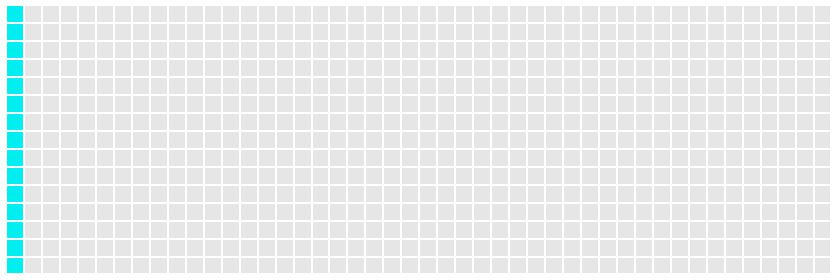

In [93]:
fig = plt.figure(
    FigureClass=Waffle,
    rows=15,
    columns=46,
    values=fuel.vehicles,
    labels=list(fuel.fuel),
    figsize=(16, 4),
    # icons="car-side",
    colors=[
        "#00eeef",
        "#e6e6e6",
        "#e6e6e6",
        "#e6e6e6",
        "#e6e6e6",
        "#e6e6e6",
        "#e6e6e6",
        "#e6e6e6",
        "#e6e6e6",
    ],
)

fig.axes[0].get_legend().remove()

fig.savefig("visuals/waffles_extended.svg")

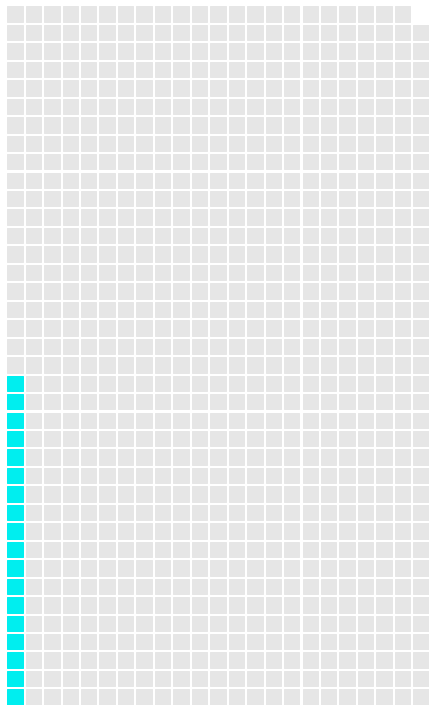

In [94]:
fig = plt.figure(
    FigureClass=Waffle,
    rows=38,
    columns=23,
    values=fuel.vehicles,
    labels=list(fuel.fuel),
    figsize=(8, 10),
    # icons="car-side",
    colors=[
        "#00eeef",
        "#e6e6e6",
        "#e6e6e6",
        "#e6e6e6",
        "#e6e6e6",
        "#e6e6e6",
        "#e6e6e6",
        "#e6e6e6",
        "#e6e6e6",
    ],
)

fig.axes[0].get_legend().remove()

fig.savefig("visuals/waffles_mobile.svg")

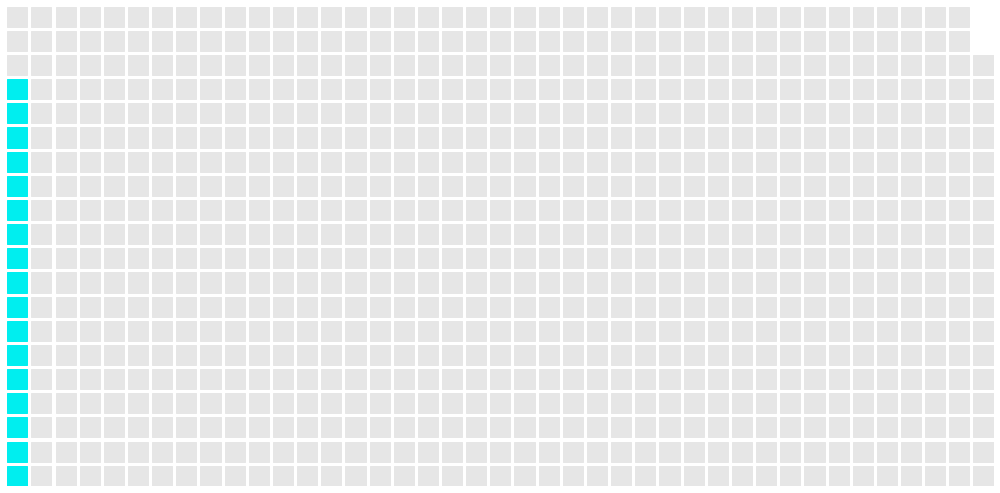

In [95]:
fig = plt.figure(
    FigureClass=Waffle,
    rows=20,
    columns=41,
    values=fuel.vehicles,
    labels=list(fuel.fuel),
    figsize=(14, 20),
    # icons="car-side",
    colors=[
        "#00eeef",
        "#e6e6e6",
        "#e6e6e6",
        "#e6e6e6",
        "#e6e6e6",
        "#e6e6e6",
        "#e6e6e6",
        "#e6e6e6",
        "#e6e6e6",
    ],
)

fig.axes[0].get_legend().remove()

fig.savefig("visuals/waffles_tablet_desktop.svg")

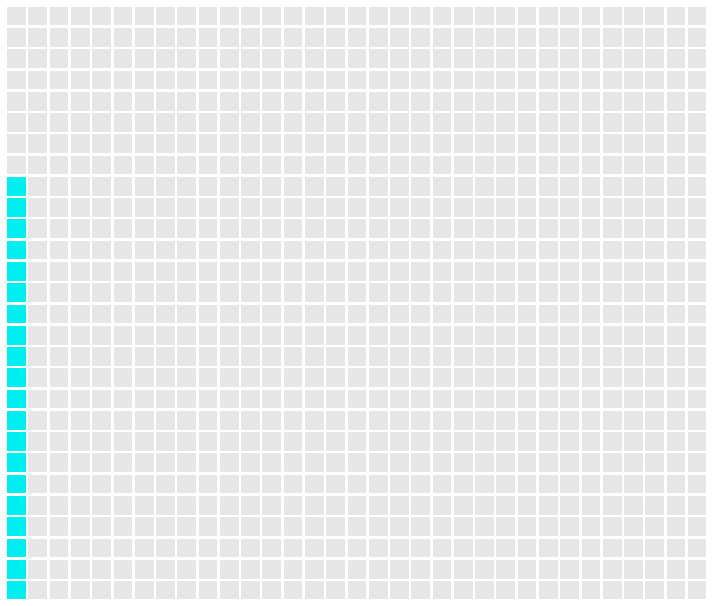

In [96]:
fig = plt.figure(
    FigureClass=Waffle,
    rows=28,
    columns=33,
    values=fuel.vehicles,
    labels=list(fuel.fuel),
    figsize=(10, 10),
    # icons="car-side",
    colors=[
        "#00eeef",
        "#e6e6e6",
        "#e6e6e6",
        "#e6e6e6",
        "#e6e6e6",
        "#e6e6e6",
        "#e6e6e6",
        "#e6e6e6",
        "#e6e6e6",
    ],
)

fig.axes[0].get_legend().remove()

fig.savefig("visuals/waffles_tablet.svg")

See related [Twitter thread](https://twitter.com/stiles/status/1193416749116358656)